In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [2]:
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

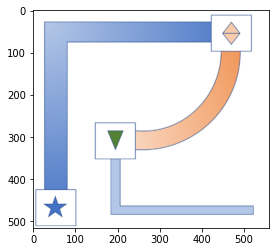

In [3]:
frame = cv2.imread("Picture1.png")
imshow(frame)

516


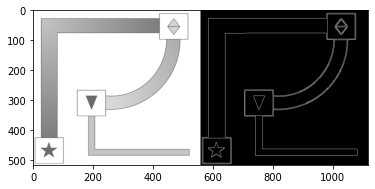

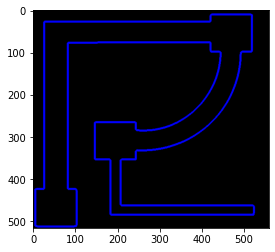

In [4]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 70, 250)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(edges))
black = np.zeros(frame.shape[:4], dtype="uint8") # For visualize
cv2.drawContours(black, contours, -1, (255, 0, 0), 3)
img = np.hstack((gray, edges))
imshow(img)
imshow(black)

1


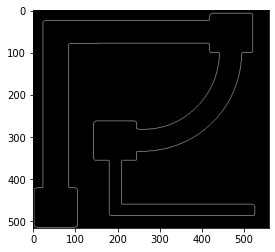

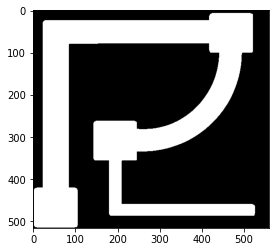

In [5]:
edges = cv2.Canny(black, 70, 250)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))
black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize
cv2.drawContours(black, contours, -1, 255, 1)
imshow(black)
black = np.zeros(frame.shape[:2], dtype="uint8") # For visualize
filled = cv2.fillPoly(black, contours, 255)
imshow(filled)

91


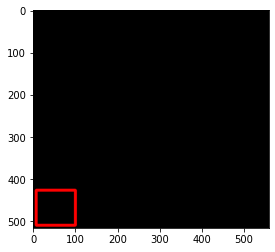

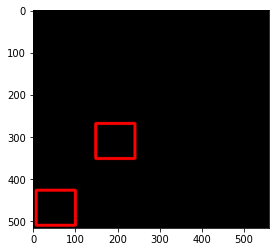

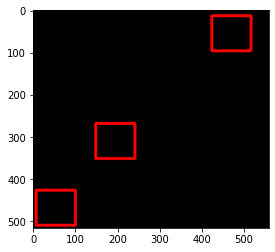

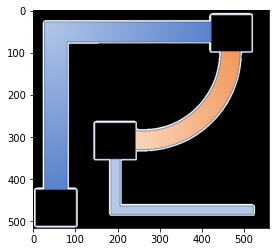

1


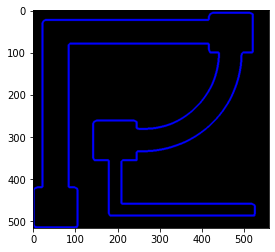

In [6]:
def is_contour_rect(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return len(approx) == 4
def is_contour_square(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    area = cv2.contourArea(approx)
    if area == 0: return False
    rect = cv2.boundingRect(approx)
    s_area = rect[2] * rect[3]
    return s_area/area > 0.9 and area/s_area > 0.9
LUV = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
# Find edges
edges = cv2.Canny(LUV, 20, 100)
contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)        
print(len(contours))
black = np.zeros(frame.shape[:4], dtype="uint8") # For visualize
marker_mask = np.ones(frame.shape[:2], dtype="uint8") * 255
for i, c in enumerate(contours):
    if is_contour_rect(c):
        if is_contour_square(c):
            cv2.drawContours(marker_mask, [c], -1, 0, -1)
            cv2.drawContours(black, contours, i, (0, 0, 255), 6)
            imshow(black)
frame_path = cv2.bitwise_and(frame, frame, mask=filled)
frame_path = cv2.bitwise_and(frame_path, frame_path, mask=marker_mask)
imshow(frame_path)

edges = cv2.Canny(frame_path, 70, 250)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))
black = np.zeros(frame.shape[:4], dtype="uint8") # For visualize
cv2.drawContours(black, contours, -1, (255, 0, 0), 3)
imshow(black)

3


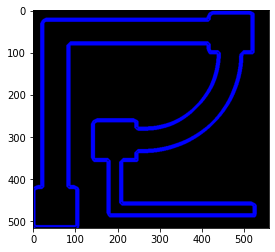

In [7]:
edges = cv2.Canny(black, 70, 250)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))
black = np.zeros([516, 559, 3], np.uint8)
cv2.drawContours(black, contours, -1, (255, 0, 0), 3)
imshow(black)